In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import numpy as np 
import warnings
import shapely
import rasterio
from pathlib import Path
import os
import pandas as pd
warnings.filterwarnings("ignore")
def read_gpkg(fnm,layer='perimeter'):
    ''' read gpkg data
    op: 'perimeter', 'fireline', 'newfirepix'
    '''

    gdf = gpd.read_file(fnm,layer=layer)

    return gdf

In [13]:
# Path to your GeoPackage file
gpkg_path = "Largefire/LargeFires_2020.gpkg"

# List all layers in the GeoPackage
layers = fiona.listlayers(gpkg_path)
print("Layers in GeoPackage:", layers)

# List to hold the data from each file
dataframes = []
# Loop through each file and read the data
for file in Path.cwd().glob("Largefire/*.gpkg"):
    # Assuming you want to read the same layer from each GeoPackage
    # Replace 'your_layer_name' with the actual name of the layer you want to read
    if os.path.exists(file):
        gdf = gpd.read_file(file, layer='perimeter')
        dataframes.append(gdf)

# Combine all GeoDataFrames into one
combined_gdf = pd.concat(dataframes, ignore_index=True)


Layers in GeoPackage: ['perimeter', 'fireline', 'newfirepix']


In [14]:
# Specify the fireID you want to filter by
specific_fireID = 3649
  # Replace with the fireID you are interested in

# Filter rows that match the specific fireID
filtered_gdf = (combined_gdf[combined_gdf['fireID'] == specific_fireID])

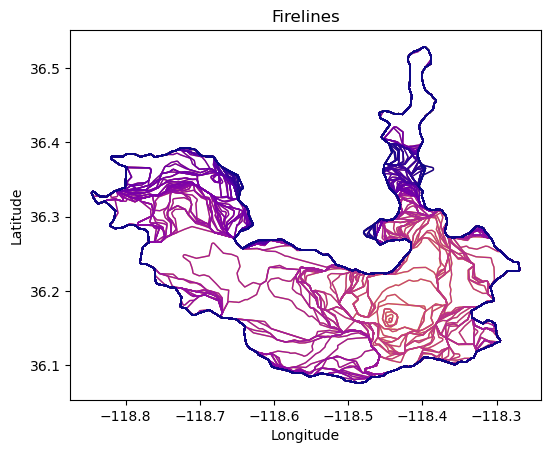

In [15]:

# Create a color map
num_rows = len(filtered_gdf)
colors = plt.cm.plasma(np.linspace(0, 1, num_rows))[::-1]

# Plot each row with a different color
fig, ax = plt.subplots()
for i,(idx, row )in enumerate(filtered_gdf.iterrows()):
    row_gdf = gpd.GeoDataFrame([row], columns=filtered_gdf.columns)
    row_gdf.plot(ax=ax,edgecolor=colors[i],facecolor='none',label=f'Fireline {i+1}')
    

# Setting the title and labels
ax.set_title('Firelines')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [18]:
minx, miny, maxx, maxy = filtered_gdf.total_bounds


In [19]:
shape = filtered_gdf
shape = shape['geometry']

In [27]:
minx, miny, maxx, maxy = filtered_gdf.total_bounds
pixel_size = 0.001  # Adjust the pixel size as needed

# Create a mesh grid of points
x_coords = np.arange(minx, maxx, pixel_size)
y_coords = np.arange(miny, maxy, pixel_size)
xx, yy = np.meshgrid(x_coords, y_coords)



points = [shape.contains(shapely.Point(x, y)) for x, y in zip(xx.ravel(), yy.ravel())]
raster = np.array(points)
raster = raster.reshape(xx.shape)



KeyboardInterrupt: 

In [21]:
# Print max and min latitude and longitude
print(f"Minimum Longitude: {minx}")
print(f"Maximum Longitude: {maxx}")
print(f"Minimum Latitude: {miny}")
print(f"Maximum Latitude: {maxy}")

Minimum Longitude: -118.84574118345924
Maximum Longitude: -118.2692500579384
Minimum Latitude: 36.07586761024662
Maximum Latitude: 36.52858279231288


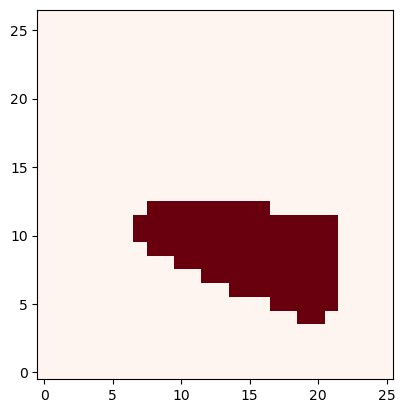

In [24]:
# Plotting
plt.imshow(raster, origin='lower', cmap='Reds')
plt.show()

In [22]:
import netCDF4 # import libraries

In [79]:
# Assuming 'perimeter_gdf' is your GeoDataFrame
minx, miny, maxx, maxy = filtered_gdf.total_bounds

In [85]:
from datetime import datetime
from netCDF4 import num2date, date2num


2020-11-07T00:00:00


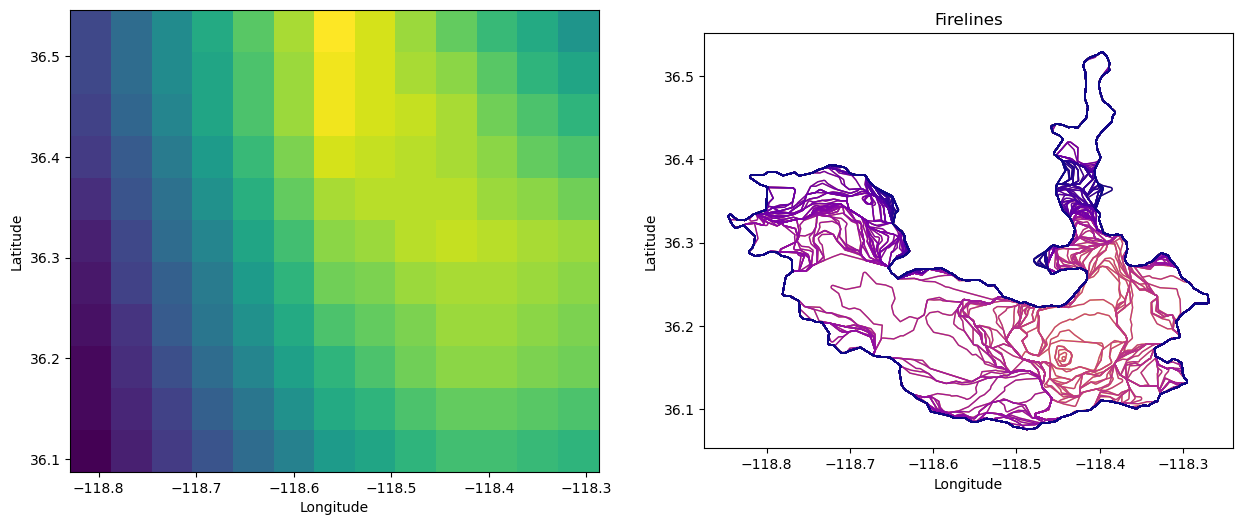

In [89]:
your_date = datetime.strptime(filtered_gdf['time'].iloc[1], '%Y-%m-%dT%H:%M:%S')  # Example date in YYYY-MM-DD format
reference_date = datetime.strptime('1900-01-01', '%Y-%m-%d')
days_since_ref = (your_date - reference_date).days

# Load the 'day' variable from the NetCDF file
nc_dataset = netCDF4.Dataset(nc_file_path, mode='r')
days = nc_dataset.variables['day'][:]

# Find the index of the closest day
closest_day_index = np.abs(days - days_since_ref).argmin()


# Extracting longitude, latitude, and wind speed data
lon = nc_dataset.variables['lon'][:]
lat = nc_dataset.variables['lat'][:]
wind_speed = nc_dataset.variables['wind_speed'][:]  # Assuming wind_speed has a day dimension

# Specify the day you are interested in
specific_day_index = 0  # Replace with the index of the day you want to plot

# Extract wind speed data for the specific day
wind_speed_day = wind_speed[closest_day_index, :, :]

# Close the NetCDF file
nc_dataset.close()

# Create boolean masks for filtering
lon_mask = (lon >= minx) & (lon <= maxx)
lat_mask = (lat >= miny) & (lat <= maxy)

# Filter the wind speed data
wind_speed_filtered = wind_speed_day[np.ix_(lat_mask, lon_mask)]

# Plot wind speed data on the first subplot
# Create a meshgrid for plotting
lon_filtered = lon[lon_mask]
lat_filtered = lat[lat_mask]
LON, LAT = np.meshgrid(lon_filtered, lat_filtered)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting
axs[0].pcolormesh(LON, LAT, wind_speed_filtered, shading='auto')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
# Create a color map
num_rows = len(filtered_gdf)
colors = plt.cm.plasma(np.linspace(0, 1, num_rows))[::-1]

# Plot each row with a different color
for i,(idx, row )in enumerate(filtered_gdf.iterrows()):
    row_gdf = gpd.GeoDataFrame([row], columns=filtered_gdf.columns)
    row_gdf.plot(ax=axs[1],edgecolor=colors[i],facecolor='none',label=f'Fireline {i+1}')
    

# Setting the title and labels
axs[1].set_title('Firelines')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
plt.show()

In [93]:
landcover_file = "/Users/jmacshane/Downloads/usa_land_cover_2020_30m_tif/ASK_NALCMS_landcover_2020_30m/data/ASK_NALCMS_landcover_2020_30m.tif"

In [99]:
from PIL import Image
from rasterio.windows import Window

min_x, min_y, max_x, max_y = 100, 100, 300, 300

with rasterio.open(landcover_file) as src:
    # Calculate the window position
    window = Window.from_slices((min_y, max_y), (min_x, max_x))

    # Read the data from the window
    cropped_image = src.read(window=window)

    # Save the cropped image to a new file
    with rasterio.open(
        'cropped_image.tif', 
        'w', 
        driver='GTiff',
        height=window.height,
        width=window.width,
        count=src.count,
        dtype=src.dtypes[0],
        crs=src.crs,
        transform=src.window_transform(window)
    ) as dst:
        dst.write(cropped_image)
